<a href="https://colab.research.google.com/github/xzj2004/ailearn/blob/main/notebooks/train-yolov12-object-detection-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Fri Jun 20 12:38:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [4]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 87.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [5]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-06-20 12:41:24--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-06-20 12:41:24 (119 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 51.4M/51.4M [00:00<00:00, 119MB/s]


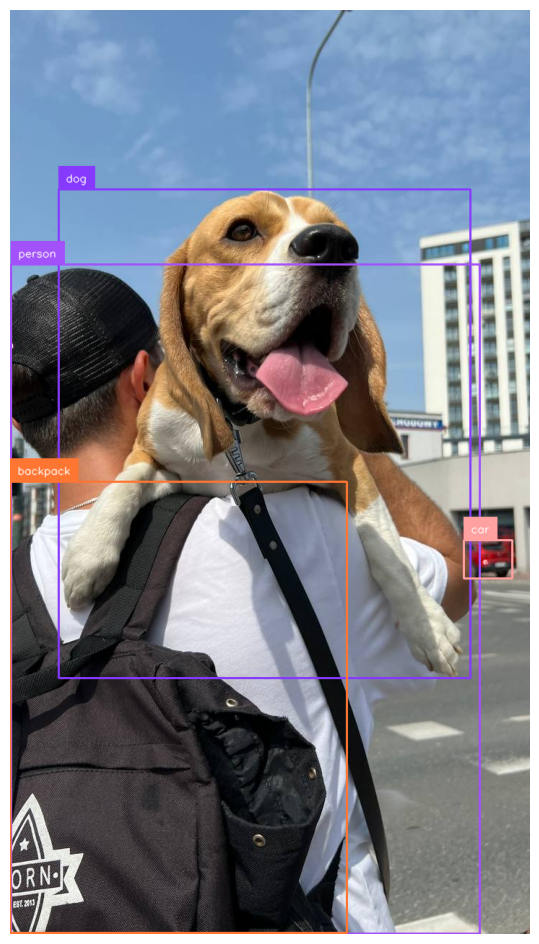

In [6]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [33]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="nSggBt2ylNioyiIFoaWI")
project = rf.workspace("wr666").project("hanpan777")
version = project.version(2)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to hanpan777-2 in yolov12:: 100%|██████████| 164/164 [00:00<00:00, 3057.34it/s]


In [34]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [35]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [36]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['hanpan']

roboflow:
  workspace: wr666
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [37]:
from ultralytics import YOLO

model = YOLO('yolov12n.pt')

results = model.train(data=f'{dataset.location}/data.yaml',batch=32,
  imgsz=640,
  scale=0.5,  # S:0.9; M:0.9; L:0.9; X:0.9
  mosaic=1.0,
  mixup=0.0,  # S:0.05; M:0.15; L:0.15; X:0.2
  copy_paste=0.1,  # S:0.15; M:0.4; L:0.5; X:0.6
  device="0",epochs=100)

New https://pypi.org/project/ultralytics/8.3.157 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12n.pt, data=/content/hanpan777-2/data.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

train: Scanning /content/hanpan777-2/train/labels... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<00:00, 896.42it/s]

train: WARNING ⚠️ /content/hanpan777-2/train/images/photo_1750415414_jpg.rf.16f0bc4bc35e5f4066de5afeaaa46f31.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/hanpan777-2/train/images/photo_1750415414_jpg.rf.61906c44e3a29de8f76d0e98c21f8b5f.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/hanpan777-2/train/images/photo_1750415414_jpg.rf.e78a25db70c27004b7222e1ea20fea72.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/hanpan777-2/train/images/photo_1750415447_jpg.rf.048e5d26ac7c5a5f94ce5baad9988138.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/hanpan777-2/train/images/photo_1750415447_jpg.rf.81fd85e284ad76b55222abd81bb22c72.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/hanpan777-2/train/images/photo_1750415447_jpg.rf.c14d85e74bb4963231e1fe76dac3cbbd.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/hanpan777-2/train/images/photo_1750415749_jpg.rf.86169b8a79e719b634e0f495e465eb01.jpg: 1 duplicate labels removed
train: WARNIN


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/hanpan777-2/valid/labels... 7 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7/7 [00:00<00:00, 205.47it/s]

val: New cache created: /content/hanpan777-2/valid/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      10.5G      2.164      3.167      1.964         87        640: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


                   all          7        446     0.0467       0.22     0.0555      0.018

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.28G      2.118      3.108       2.01        151        640: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all          7        446     0.0505      0.238     0.0582      0.021



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.47G        2.1      2.953      2.106        101        640: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


                   all          7        446      0.059      0.278     0.0794     0.0313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      9.69G      1.913      2.867      1.939        207        640: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

                   all          7        446       0.07       0.33     0.0968      0.042



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.44G      1.687      2.826      1.802        280        640: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all          7        446     0.0767      0.361      0.109     0.0494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      9.65G      1.674      2.756       1.71        178        640: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all          7        446     0.0762      0.359      0.112     0.0529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       8.9G      1.774      2.524      1.841        180        640: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all          7        446     0.0805      0.379      0.127      0.056



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.51G      1.636      2.438      1.633        301        640: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


                   all          7        446     0.0876      0.413      0.141     0.0616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.72G      1.635      2.162      1.677        382        640: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all          7        446     0.0976       0.46      0.162     0.0769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.16G      1.803      2.019      1.807        126        640: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all          7        446     0.0843      0.397      0.127     0.0569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.22G      1.628       1.85      1.706        275        640: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all          7        446     0.0795      0.374     0.0985      0.043



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.43G      1.658        1.7      1.701        149        640: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

                   all          7        446     0.0857      0.404      0.126     0.0547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.65G      1.546      1.541      1.694        104        640: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all          7        446     0.0867      0.408       0.15     0.0724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.59G      1.544      1.563      1.643        162        640: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all          7        446     0.0829       0.39       0.14      0.065



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       9.2G      1.556      1.448      1.687        152        640: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all          7        446     0.0757      0.357      0.137     0.0622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.66G      1.646      1.412      1.762        195        640: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all          7        446      0.162      0.209      0.111      0.042



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      10.1G      1.565      1.431      1.756        185        640: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all          7        446      0.189      0.168     0.0999     0.0375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      9.59G      1.571      1.284      1.726        225        640: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all          7        446      0.293       0.13      0.127     0.0526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.83G      1.608      1.417      1.749        107        640: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all          7        446      0.334      0.135      0.136     0.0586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       8.8G      1.576      1.377      1.608        107        640: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all          7        446      0.192      0.162      0.121     0.0519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      10.6G      1.461      1.274      1.679        175        640: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all          7        446      0.196      0.202      0.133     0.0589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      9.75G      1.468      1.185      1.663        249        640: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

                   all          7        446      0.152      0.274      0.136     0.0602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      10.2G      1.483       1.25      1.702        169        640: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

                   all          7        446      0.168      0.209      0.134     0.0612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      9.12G       1.52      1.212      1.716        166        640: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all          7        446      0.355      0.165      0.184     0.0875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      9.63G       1.44      1.153      1.553        234        640: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all          7        446       0.37      0.155      0.188     0.0859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      9.71G      1.432      1.161      1.536        211        640: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all          7        446      0.268      0.168      0.148     0.0664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.92G       1.44      1.222      1.659        101        640: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all          7        446      0.166      0.191      0.132     0.0548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      9.12G      1.448      1.135      1.645        294        640: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

                   all          7        446      0.164      0.269      0.132     0.0545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       9.6G      1.393      1.123      1.596        219        640: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all          7        446        0.2      0.233      0.151     0.0653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      9.64G      1.357      1.088      1.569        214        640: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all          7        446      0.235      0.164      0.143     0.0665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      9.26G      1.372      1.078      1.579        377        640: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all          7        446      0.244      0.195      0.165     0.0748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      9.08G      1.477      1.141      1.724        205        640: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all          7        446      0.288       0.24      0.192      0.085



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      9.81G      1.368      1.092      1.565        263        640: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all          7        446      0.247      0.229       0.18     0.0836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      9.13G      1.462      1.113      1.626        192        640: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all          7        446      0.346      0.202      0.208      0.095



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.95G      1.396      1.065       1.57        266        640: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all          7        446      0.421      0.217      0.248      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      9.92G      1.362      1.071      1.543        259        640: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all          7        446      0.436      0.271      0.279       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      9.33G      1.344      1.047      1.535        217        640: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

                   all          7        446      0.478      0.269      0.295      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      9.75G       1.44      1.057      1.599        290        640: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

                   all          7        446      0.387      0.276      0.272      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      9.45G      1.364      1.041      1.561        199        640: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

                   all          7        446      0.302      0.323      0.232      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      9.21G       1.36      1.054      1.553        206        640: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all          7        446      0.323      0.305      0.239      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       9.1G      1.376      1.051      1.565        218        640: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]

                   all          7        446       0.27      0.327       0.22      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100       9.4G      1.354      1.033      1.481        147        640: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all          7        446      0.279      0.309      0.205     0.0958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      9.89G      1.288     0.9967      1.499        158        640: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all          7        446      0.274      0.268      0.206      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      9.67G      1.356      1.006      1.571        182        640: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all          7        446      0.287      0.298      0.226      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      10.1G      1.323      1.033      1.493        155        640: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all          7        446      0.286      0.316      0.236      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      9.21G      1.287      1.074      1.491        125        640: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all          7        446      0.318      0.361      0.284      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      9.19G      1.338      1.027      1.535        342        640: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

                   all          7        446      0.356      0.365      0.275       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      10.6G      1.293     0.9817      1.517        226        640: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all          7        446      0.319      0.402       0.29      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      9.69G      1.198     0.9507       1.41        132        640: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all          7        446      0.371      0.343      0.292      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      9.49G      1.328      1.017      1.449        319        640: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all          7        446      0.396      0.334      0.298       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      9.07G      1.242      0.935      1.424        207        640: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all          7        446       0.32      0.332      0.274      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      9.03G      1.249     0.9714      1.422        218        640: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all          7        446      0.323      0.339      0.252      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      9.87G      1.278     0.9692      1.457        133        640: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all          7        446      0.373      0.291      0.261      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      10.3G       1.28     0.9309      1.475        364        640: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


                   all          7        446      0.309      0.302      0.255      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      9.88G      1.304     0.9667      1.483        114        640: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all          7        446      0.456      0.256      0.261      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      9.77G      1.329     0.9942      1.522        219        640: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all          7        446      0.413      0.336      0.303      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      9.51G      1.216      0.923      1.418        129        640: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all          7        446      0.399      0.285      0.285      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.99G      1.208     0.9717      1.442        244        640: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all          7        446       0.43      0.332      0.305      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.91G      1.254     0.9426      1.467        387        640: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all          7        446      0.393      0.359      0.311      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      9.47G      1.247       0.92       1.43        184        640: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all          7        446      0.411      0.412      0.337       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      9.59G      1.222     0.9163      1.398        252        640: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

                   all          7        446        0.4       0.39      0.336      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.76G      1.159     0.9402      1.383        180        640: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


                   all          7        446      0.415       0.35      0.325      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       9.5G      1.224     0.8684      1.385        406        640: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

                   all          7        446      0.411      0.375       0.34      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.96G      1.158     0.8617      1.376        302        640: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all          7        446      0.443      0.379      0.334      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      9.79G      1.179     0.9587      1.375        114        640: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

                   all          7        446      0.466      0.342      0.344       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      10.6G      1.254     0.9397      1.395        254        640: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all          7        446      0.432      0.355      0.333      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      9.51G      1.212     0.9105      1.427        402        640: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all          7        446      0.431      0.368      0.344      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      9.82G      1.176     0.8609      1.386        264        640: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all          7        446      0.466       0.37      0.356      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.47G      1.204     0.9362      1.428        150        640: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all          7        446       0.51       0.37      0.364      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      9.76G      1.132     0.8575       1.39        215        640: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all          7        446      0.487      0.386      0.348      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      9.37G       1.19     0.8738      1.378        218        640: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

                   all          7        446      0.464      0.374      0.334      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      9.89G      1.083     0.9631      1.309         77        640: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all          7        446      0.415       0.41      0.332      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      9.06G      1.096     0.8256      1.339        328        640: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

                   all          7        446      0.399      0.408       0.33      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      9.87G      1.088     0.8119      1.325        183        640: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all          7        446      0.459      0.348      0.331      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      9.03G      1.142     0.8372      1.355        328        640: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

                   all          7        446      0.461      0.335      0.341      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      9.02G      1.125     0.8154      1.351        205        640: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all          7        446      0.454      0.386       0.36      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100        10G      1.115     0.8637      1.351        207        640: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all          7        446      0.413      0.401      0.356      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.91G      1.097     0.8518      1.296        152        640: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all          7        446      0.437      0.411      0.354      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      9.68G      1.229     0.8622      1.435        164        640: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all          7        446      0.432      0.403      0.347      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      9.95G      1.077     0.8173      1.302        177        640: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]

                   all          7        446      0.433      0.392      0.346      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      9.93G      1.148     0.8936      1.399        121        640: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all          7        446      0.409       0.41       0.35      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      9.01G      1.061     0.8367      1.244        151        640: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]

                   all          7        446      0.433      0.475      0.379      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      9.74G       1.09     0.8029      1.324        248        640: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all          7        446      0.433      0.457      0.384      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100        10G      1.113     0.8179      1.309        225        640: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all          7        446      0.448      0.453      0.374      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      9.08G      1.119     0.8401      1.292        146        640: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

                   all          7        446       0.44      0.426      0.352      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.71G      1.073     0.8298      1.316        320        640: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all          7        446      0.442      0.417      0.367      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      9.01G      1.126     0.8863       1.31        112        640: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all          7        446      0.455      0.428      0.379        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      9.31G      1.083     0.8381      1.304        208        640: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all          7        446      0.436      0.453      0.393      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      9.93G      1.062     0.7866      1.324        264        640: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all          7        446      0.488       0.43      0.399      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      9.85G      1.184       1.14      1.281         84        640: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

                   all          7        446      0.492      0.446      0.412      0.217


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.67G      1.065      1.063       1.29         87        640: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all          7        446      0.506      0.446       0.42      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.83G      1.072     0.9428      1.316        136        640: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

                   all          7        446      0.521      0.439      0.415      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       7.5G      1.017     0.9422      1.247         91        640: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

                   all          7        446      0.515      0.428      0.409      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.65G      1.001     0.9843      1.317         60        640: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all          7        446       0.51      0.426      0.403      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.73G      1.057     0.8733      1.282        112        640: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


                   all          7        446      0.491      0.422      0.394       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.82G     0.9267     0.7962      1.173         79        640: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all          7        446      0.511      0.413      0.376      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.66G      1.039     0.8053      1.248        163        640: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all          7        446      0.505       0.41      0.378      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.65G      1.031     0.8001       1.27        123        640: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all          7        446      0.501      0.397       0.38      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.67G      1.142     0.9096       1.31         52        640: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

                   all          7        446      0.498      0.399      0.371      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.59G      1.027      0.787      1.283        162        640: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

                   all          7        446      0.508      0.401      0.372      0.202



100 epochs completed in 0.091 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.4MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 376 layers, 2,508,539 parameters, 0 gradients, 5.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


                   all          7        446      0.498      0.439      0.408      0.217
Speed: 0.2ms preprocess, 4.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train2


## Evaluate fine-tuned YOLOv12 model

In [39]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train2/

args.yaml					   results.png
confusion_matrix_normalized.png			   train_batch0.jpg
confusion_matrix.png				   train_batch1.jpg
events.out.tfevents.1750424418.b8ef6347a844.694.1  train_batch270.jpg
F1_curve.png					   train_batch271.jpg
labels_correlogram.jpg				   train_batch272.jpg
labels.jpg					   train_batch2.jpg
P_curve.png					   val_batch0_labels.jpg
PR_curve.png					   val_batch0_pred.jpg
R_curve.png					   weights
results.csv


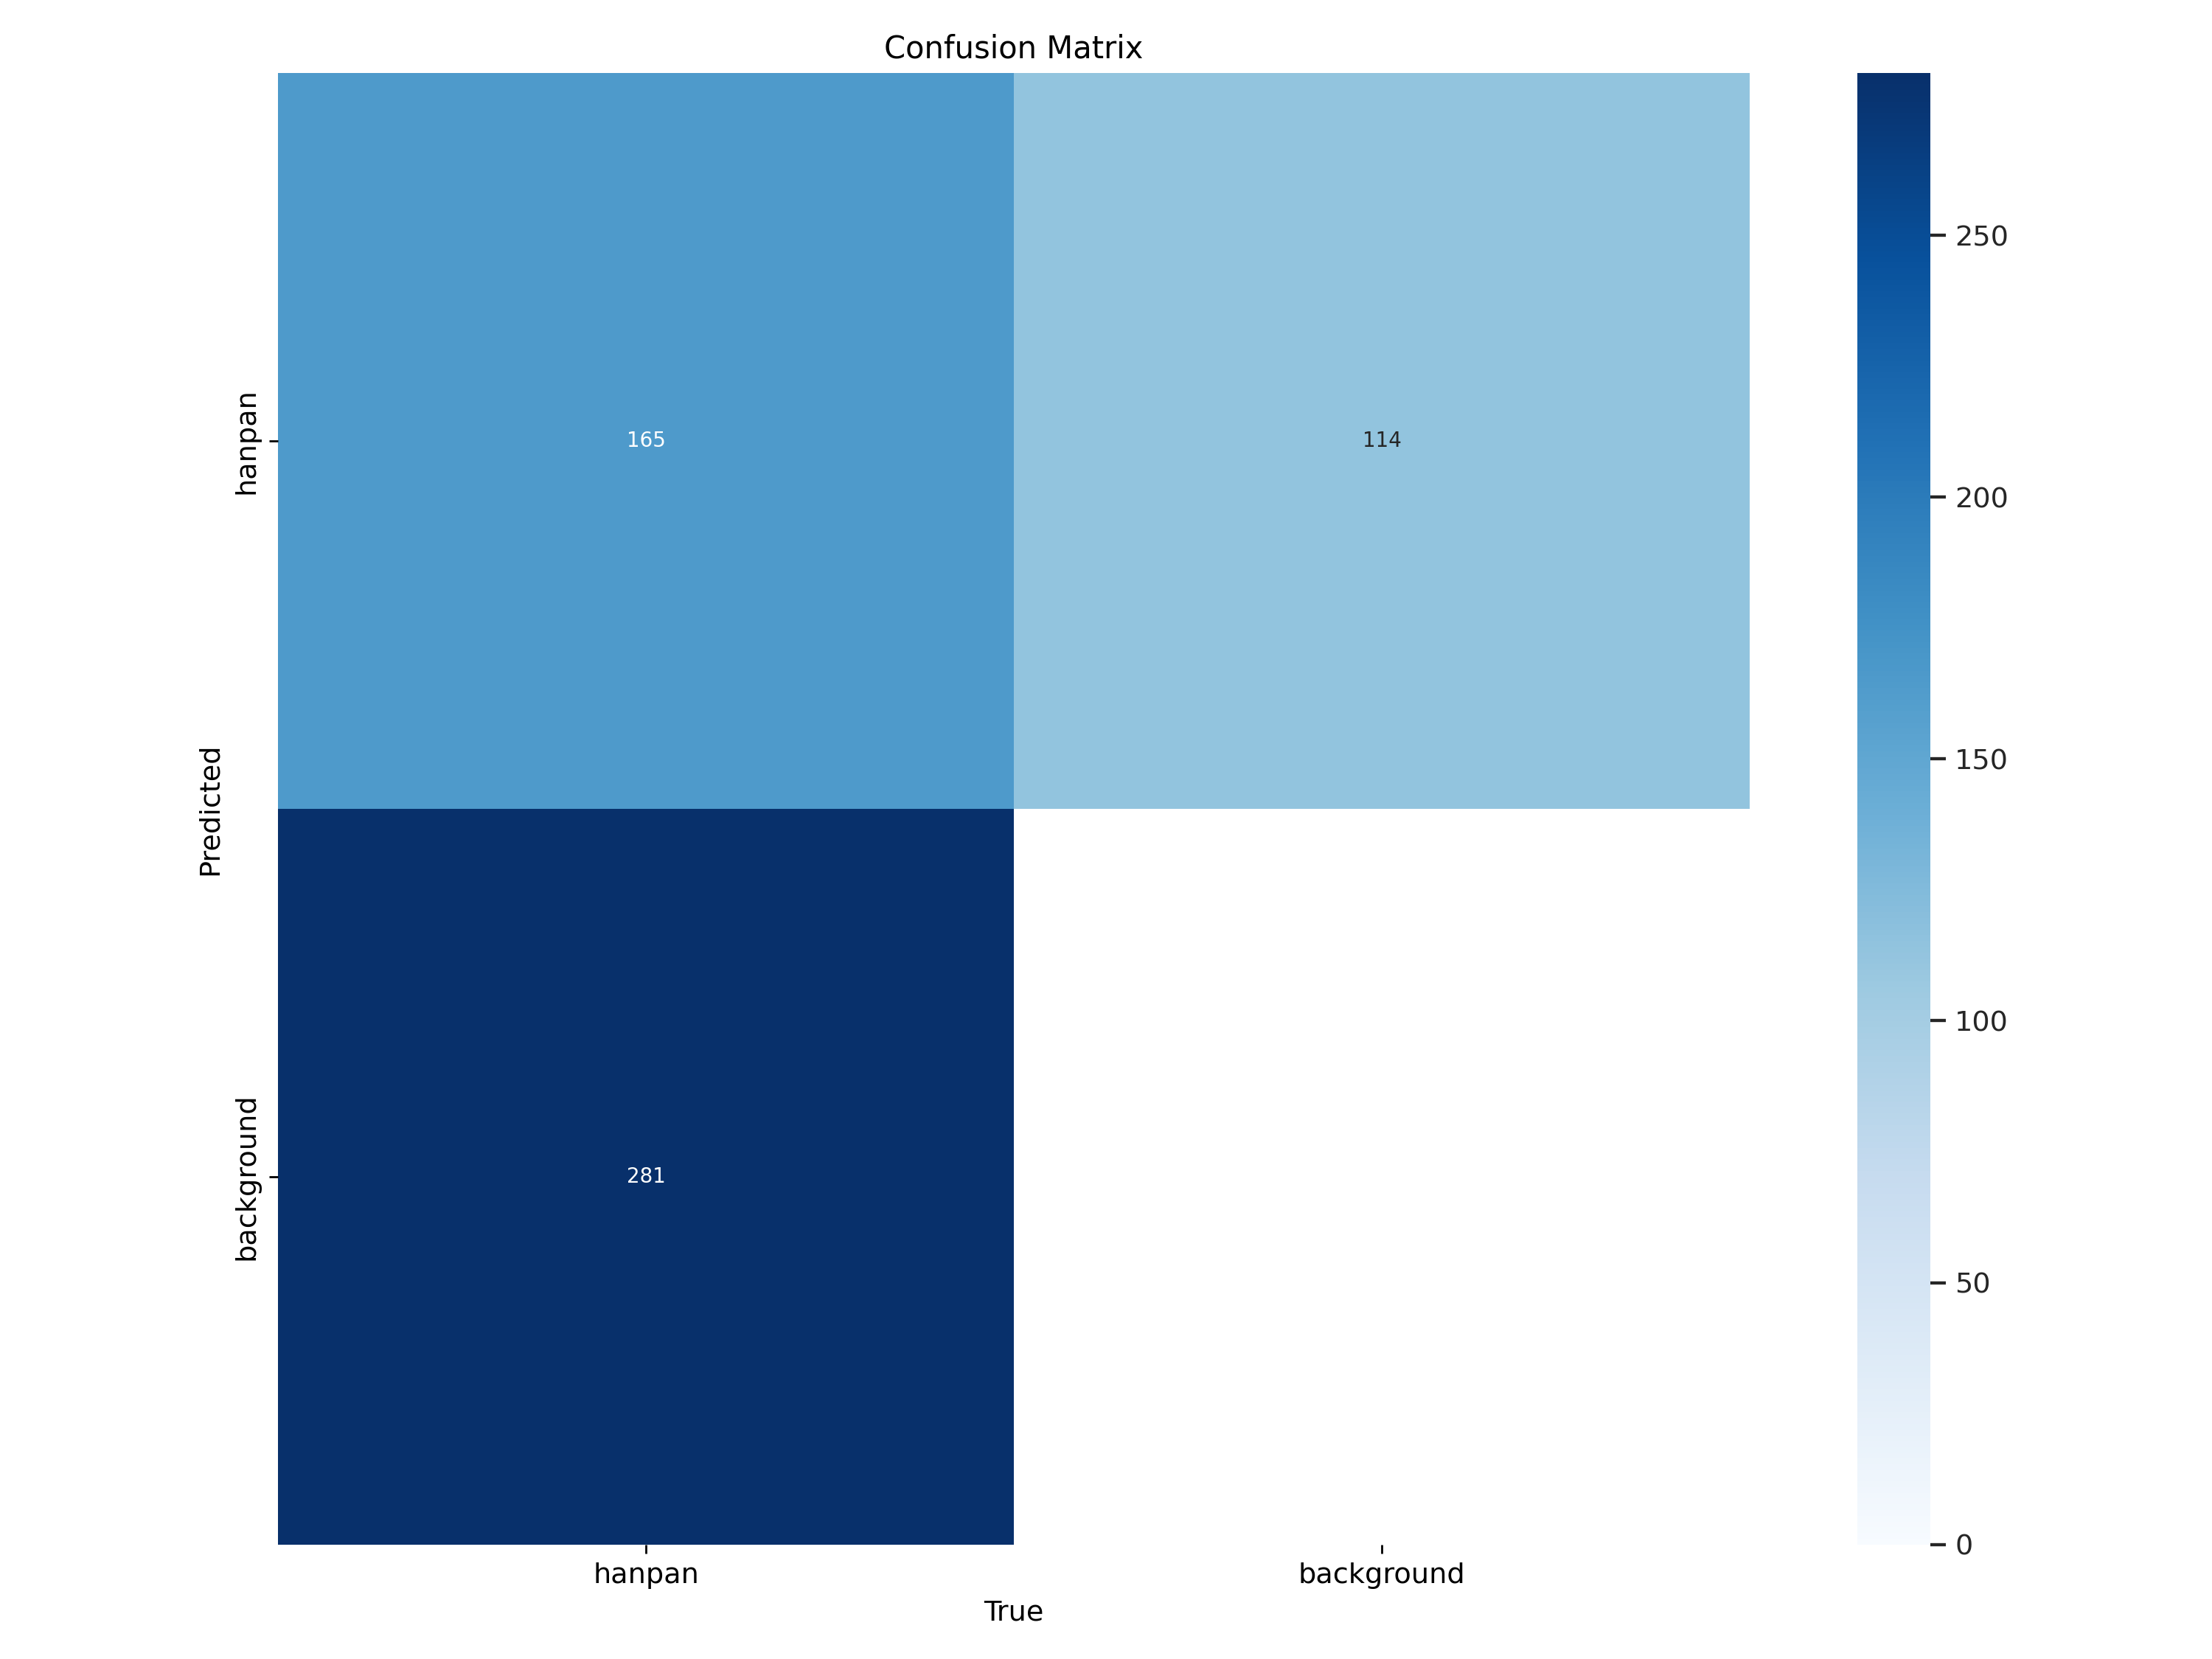

In [40]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=1000)

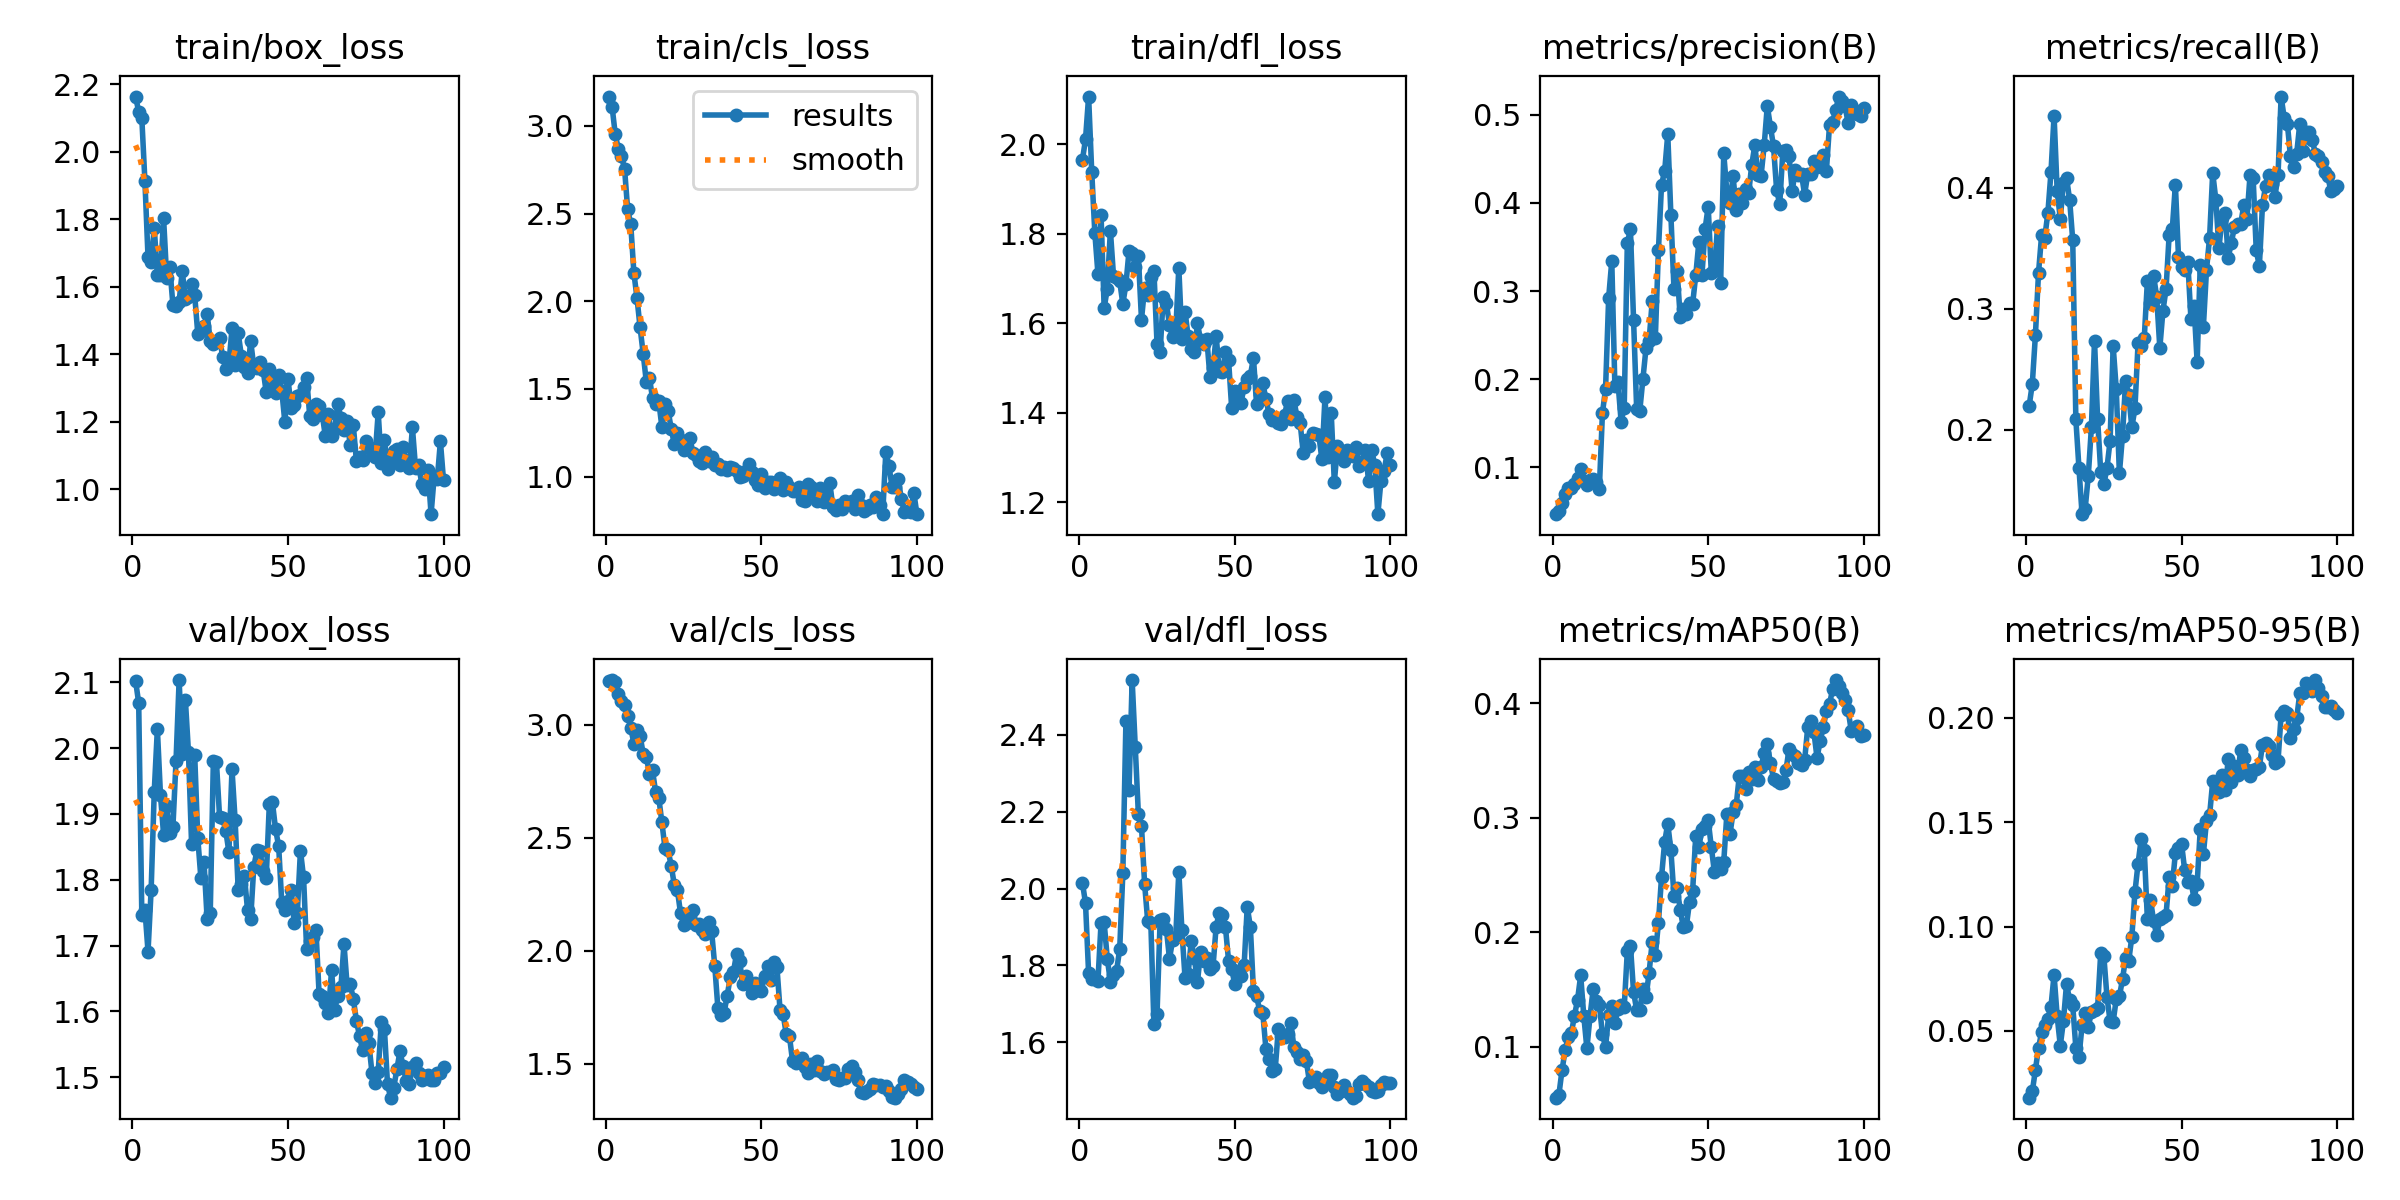

In [41]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train2/results.png', width=1000)

In [42]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['hanpan']

In [44]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train2/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [45]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.012876213739241565
mAP 50 0.019959804276576985
mAP 75 0.014406941197245955


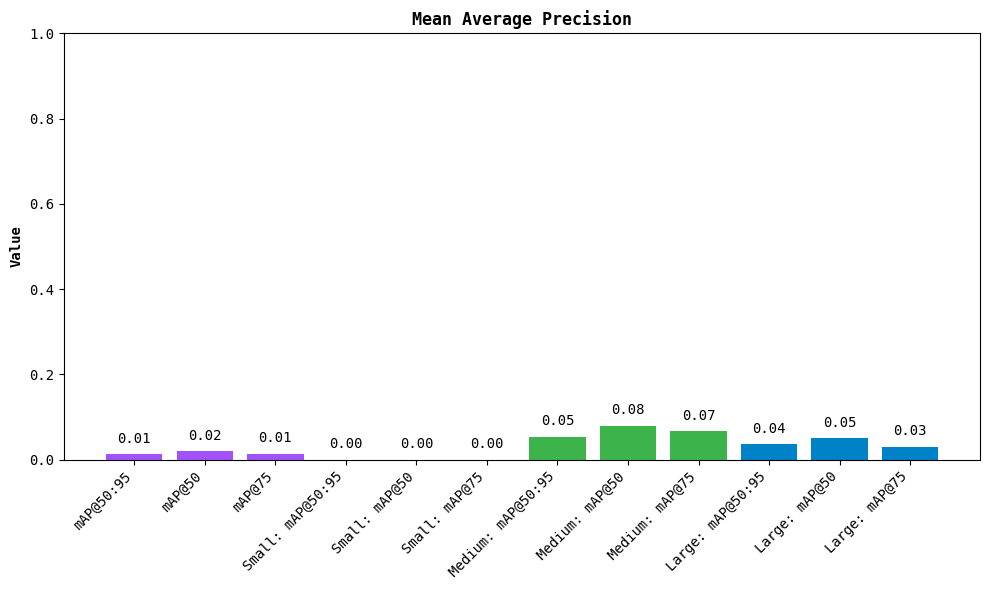

In [46]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [47]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train2/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

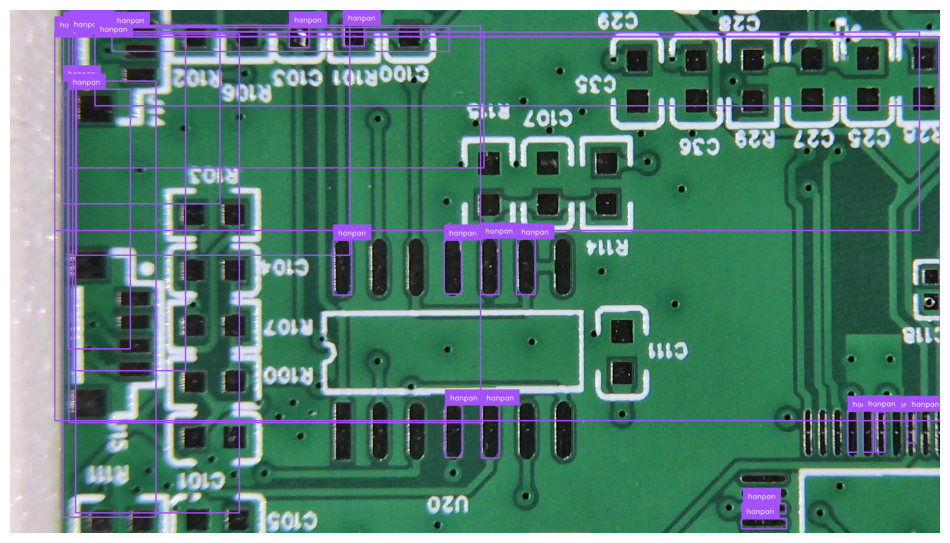

In [49]:
import random

i = random.randint(0, len(ds)-1)

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)